# Implementation of the *Price Reversal* Factor and the *...* Factor (as proposed by Andrew Lo and Pankaj Patel in "130/30: The New Long-Only")
By Vlad Obukhanich

Let us import all the necessary data for this implementation:

In [43]:
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.data import morningstar
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

import numpy as np
import pandas as pd
import alphalens
import alphalens.performance as perf 
import alphalens.utils as utils

## Price Reversal 
This factor is comprised of the following sub-factors:
- 5-Day Industry-Relative Return
- 5-Day Money Flow/Volume
- 4-Week Industry-Relative Return

### 5-Day Industry-Relative Return
Let us define a custom factor *FiveDayReturn* that will output the 5-day return for each stock in our selected universe of stocks (the sign of the return will be reversed because of the nature of this factor):

In [88]:
class FiveDayReturn(CustomFactor):  
    inputs = [USEquityPricing.close]
    window_length = 5
    
    def compute(self, today, assets, out, close):  
        out[:] = -1 * ((close[0]-close[-1]) / close[-1])

The industry-relative component of this factor will be taken care of by categorizing the stocks in our pipeline by their sector. This will be done by adding the Sector column to our pipeline that will contain Morningstar sector codes from the following dictionary:

In [89]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

Create a temporary pipeline and add the *FiveDayReturn* factor to it:

In [90]:
temp_pipe_1 = Pipeline(
    columns={
        'FiveDayReturn': FiveDayReturn(),
        'Sector': Sector(),
    }
)

Run the pipeline and get data for the first 5 stocks:

In [91]:
run_pipeline(temp_pipe_1, start_date='2017-08-18', end_date='2017-08-18').head()

FiveDayReturn  Sector
2017-08-18 00:00:00+00:00 Equity(2 [ARNC])           0.011944      -1
                          Equity(21 [AAME])          0.014493     103
                          Equity(24 [AAPL])          0.002470     311
                          Equity(25 [ARNC_PR])            NaN      -1
                          Equity(31 [ABAX])          0.023231     206

### 5-Day Money Flow/Volume
Let us define a custom factor *FiveDayMoneyFlowVol* that will output the closing price times the volume over the absolute value of the closing price times the volume for the past 5 days for each stock in our selected universe of stocks:

In [92]:
class FiveDayMoneyFlowVol(CustomFactor):  
    inputs = [USEquityPricing.close, USEquityPricing.volume]
    window_length = 5
    
    def compute(self, today, assets, out, close, vol):
        out[:] = (close[0] * vol[0]) / abs(close[0] * vol[-4])

Create a temporary pipeline and add the *FiveDayMoneyFlowVol* factor to it:

In [93]:
temp_pipe_2 = Pipeline(
    columns={
        'FiveDayMoneyFlowVol': FiveDayMoneyFlowVol(),
    }
)

Run the pipeline and get data for the first 5 stocks:

In [94]:
run_pipeline(temp_pipe_2, start_date='2017-08-18', end_date='2017-08-18').head()

FiveDayMoneyFlowVol
2017-08-18 00:00:00+00:00 Equity(2 [ARNC])                 1.148711
                          Equity(21 [AAME])                0.600000
                          Equity(24 [AAPL])                1.233850
                          Equity(25 [ARNC_PR])                  NaN
                          Equity(31 [ABAX])                1.573430

### 4-Week Industry-Relative Return
Let us define a custom factor *FourWeekReturn* that will output the 4-week return for each stock in our selected universe of stocks: (Again, the sign of the return will be reversed.)

In [95]:
class FourWeekReturn(CustomFactor):  
    inputs = [USEquityPricing.close]
    window_length = 20
    
    def compute(self, today, assets, out, close):  
        out[:] = -1 * ((close[0]-close[-1]) / close[-1])

As usual, the industry-relative component of this factor will be taken care of by categorizing the stocks in our pipeline by their sector with the help of the Morningstar dictionary.

Now, let us create a temporary pipeline and add the *FourWeekReturn* factor to it:

In [96]:
temp_pipe_3 = Pipeline(
    columns={
        'FourWeekReturn': FourWeekReturn(),
        'Sector': Sector(),
    }
)

Run the pipeline and get data for the first 5 stocks:

In [97]:
run_pipeline(temp_pipe_3, start_date='2017-08-18', end_date='2017-08-18').head()

FourWeekReturn  Sector
2017-08-18 00:00:00+00:00 Equity(2 [ARNC])           -0.035410      -1
                          Equity(21 [AAME])          -0.043478     103
                          Equity(24 [AAPL])           0.051860     311
                          Equity(25 [ARNC_PR])             NaN      -1
                          Equity(31 [ABAX])          -0.070322     206

### Create the Full Pipeline
Now, let us combine all the sub-factors of the *Price Reversal* factor into one pipeline. Let us also define another custom factor *SPYProxy* that will create an approximate S&P 500 by outputting the 500 US Equities with the greatest market capitalizations:

In [98]:
# This factor creates the synthetic S&P 500.
class SPYProxy(CustomFactor):
    inputs = [morningstar.valuation.market_cap]
    window_length = 1
    
    def compute(self, today, assets, out, mc):
        out[:] = mc[-1]

full_pipeline_1 = Pipeline(
    columns={
        'SPY Proxy': SPY_proxy(),
        'FiveDayReturn': FiveDayReturn(),
        'FiveDayMoneyFlowVol': FiveDayMoneyFlowVol(),
        'FourWeekReturn': FourWeekReturn(),
        'Sector': Sector(),
    }
)

results_1 = run_pipeline(full_pipeline_1, start_date='2016-08-18', end_date='2017-08-18')
results_1.head()

FiveDayMoneyFlowVol  \
2016-08-18 00:00:00+00:00 Equity(2 [ARNC])                 0.690695   
                          Equity(21 [AAME])                     inf   
                          Equity(24 [AAPL])                1.207420   
                          Equity(25 [ARNC_PR])             1.430000   
                          Equity(31 [ABAX])                1.537423   

                                                FiveDayReturn  FourWeekReturn  \
2016-08-18 00:00:00+00:00 Equity(2 [ARNC])          -0.005309       -0.019709   
                          Equity(21 [AAME])               NaN             NaN   
                          Equity(24 [AAPL])          0.011630        0.094465   
                          Equity(25 [ARNC_PR])       0.002645        0.011737   
                          Equity(31 [ABAX])         -0.013872       -0.116687   

                                                   SPY Proxy  Sector  
2016-08-18 00:00:00+00:00 Equity(2 [ARNC])      1.362730e+10     101  
                          Equity(21 [AAME])     7.678260e+07     103  
                          Equity(24 [AAPL])     5.885260e+11     311  
                          Equity(25 [ARNC_PR])           NaN     101  
                          Equity(31 [ABAX])     1.104570e+09     206

### Test in Alphalens
Now that we have the full pipeline with each of the *Price Reversal* sub-factors in it, let us create an Alphalens factor tear sheet for each one of them:

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                            
1               -11.857143  0.001138 -0.061012  0.106406  357359  20.008712
2                -0.058375  0.016982 -0.009922  0.010442  357733  20.029653
3                -0.036872  0.040430  0.001391  0.008681  357007  19.989003
4                -0.023345  0.096726  0.012088  0.011825  356700  19.971814
5                -0.006228  1.161301  0.052348  0.051558  357218  20.000817

Returns Analysis


1      5      10
Ann. alpha                                    -0.042 -0.040  0.027
beta                                          -0.074 -0.270 -0.260
Mean Period Wise Return Top Quantile (bps)    -0.006 -7.418 -7.001
Mean Period Wise Return Bottom Quantile (bps) -2.188  0.737  0.403
Mean Period Wise Spread (bps)                  2.227 -1.585 -0.691

Information Analysis


1      5      10
IC Mean     -0.001 -0.011 -0.014
IC Std.      0.098  0.102  0.094
t-stat(IC)  -0.088 -1.753 -2.387
p-value(IC)  0.930  0.081  0.018
IC Skew      0.368 -0.241  0.086
IC Kurtosis  1.565  0.959  0.995
Ann. IR     -0.090 -1.785 -2.431

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.367  0.709  0.711
Quantile 2 Mean Turnover   0.600  0.793  0.787
Quantile 3 Mean Turnover   0.613  0.712  0.719
Quantile 4 Mean Turnover   0.599  0.779  0.776
Quantile 5 Mean Turnover   0.381  0.746  0.746

1      5   10
Mean Factor Rank Autocorrelation  0.662 -0.011  0.0

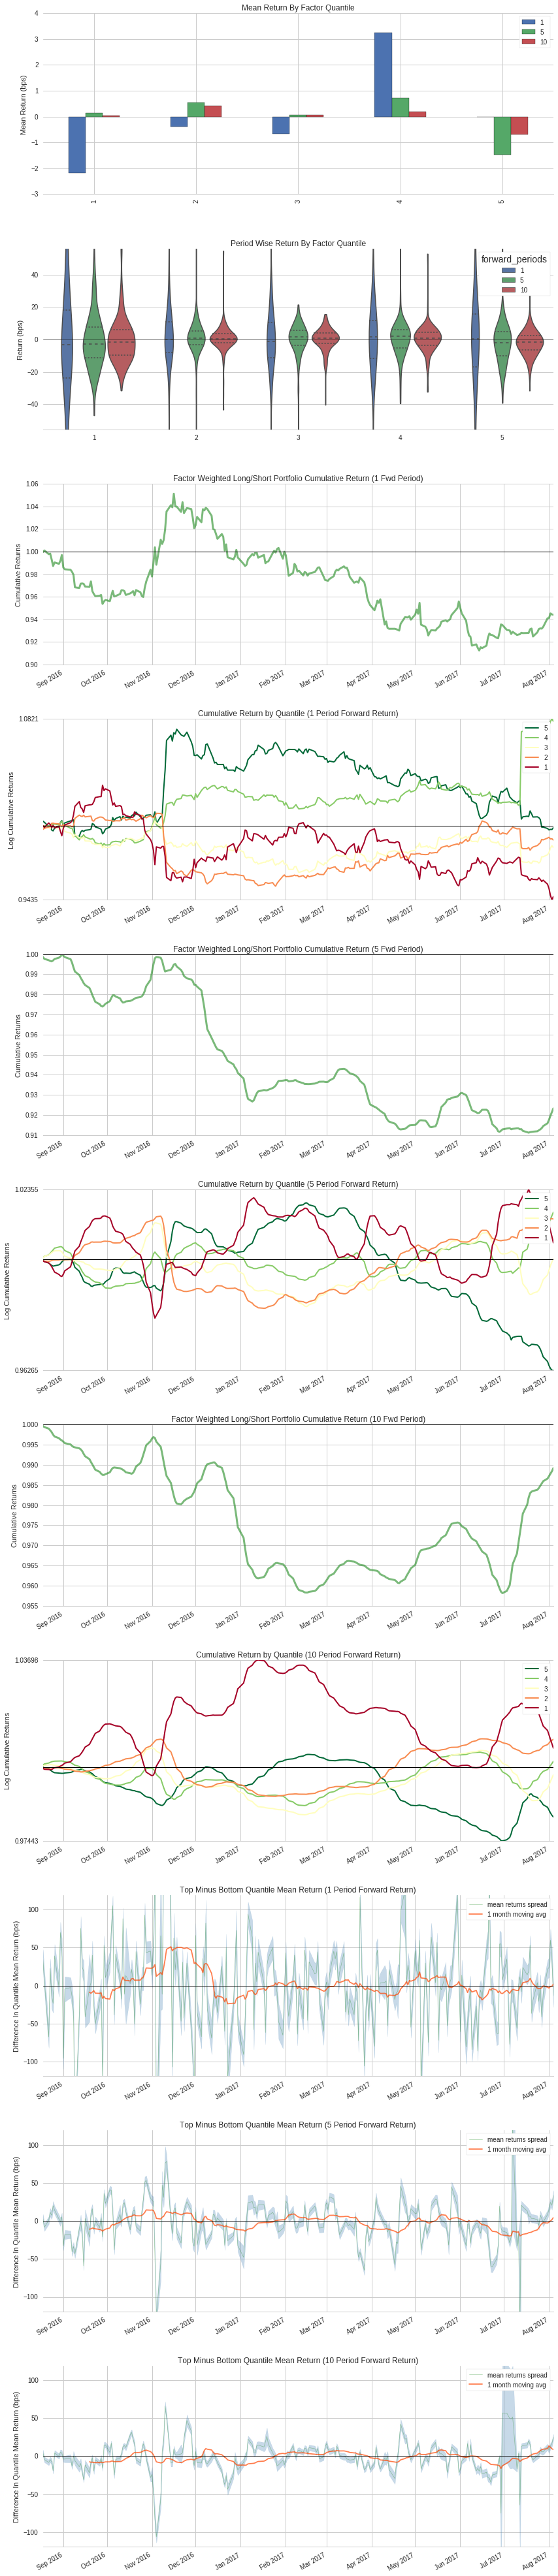

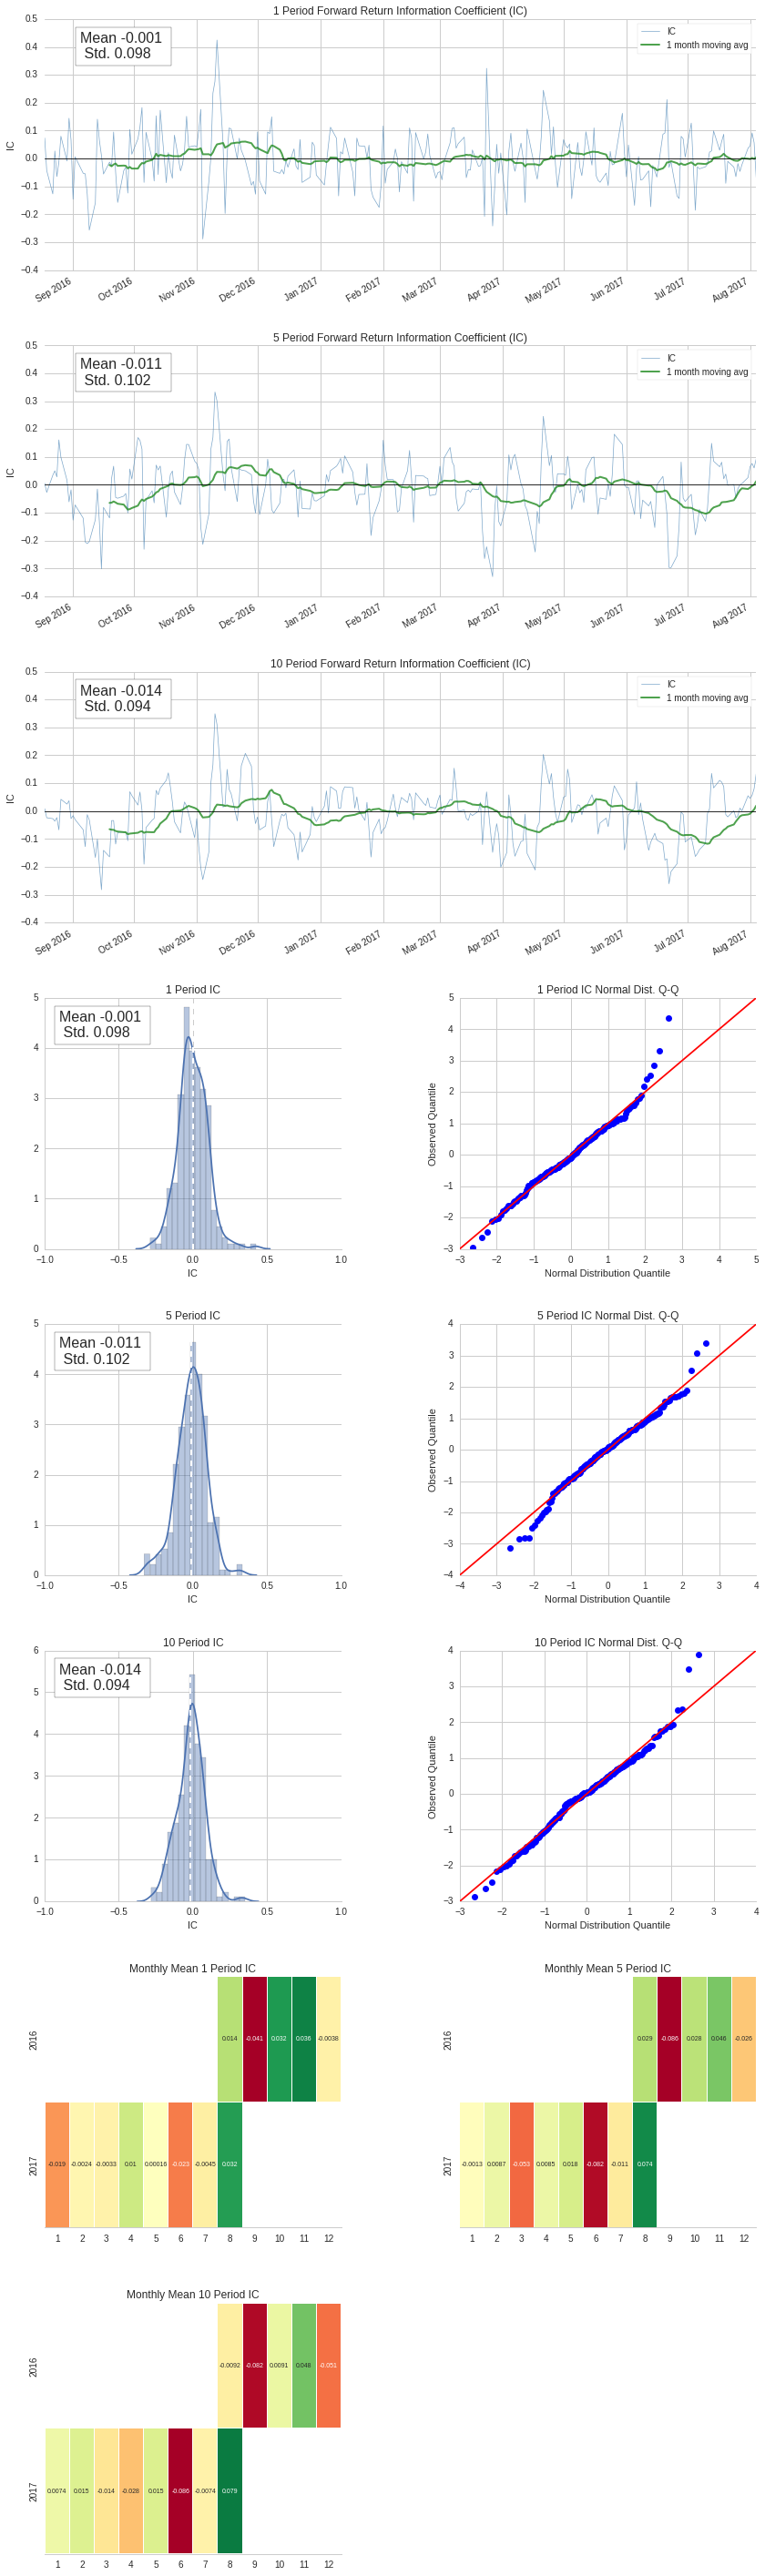

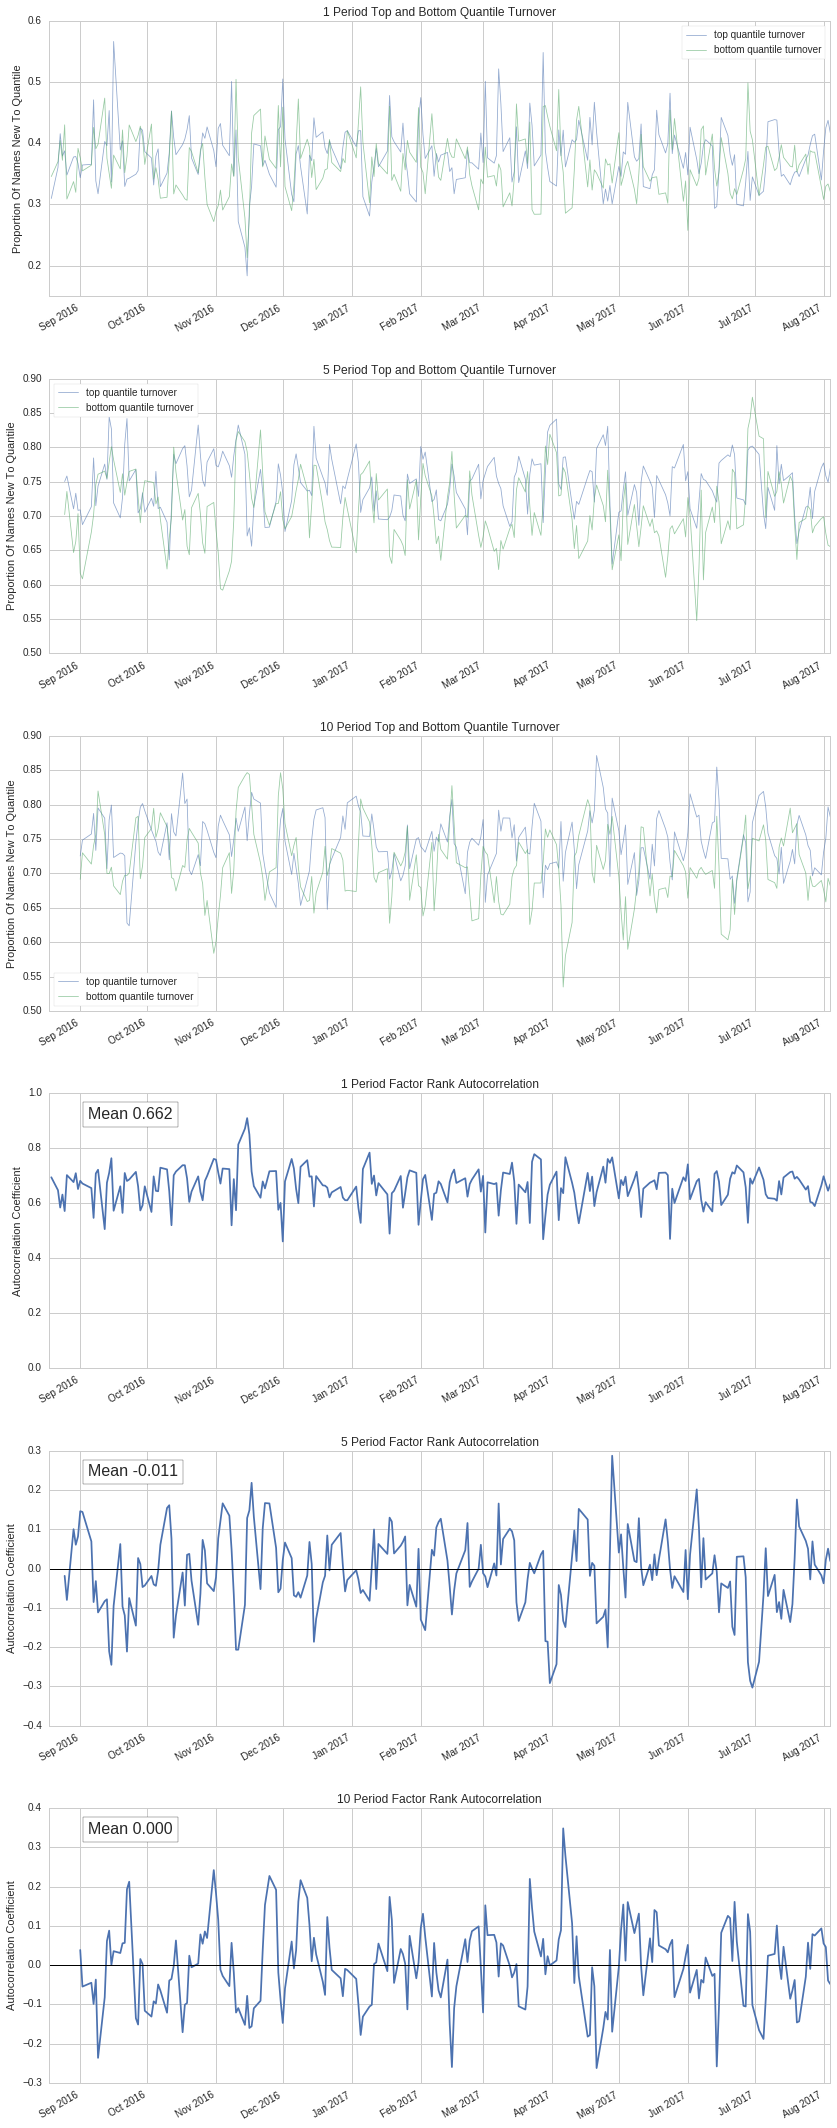

In [77]:
assets = results_1.index.levels[1].unique()  
pricing = get_pricing(assets, '2016-08-18', '2017-08-18', fields='open_price')

# Test FiveDayReturn.
factor_data_1 = alphalens.utils.get_clean_factor_and_forward_returns(results_1['FiveDayReturn'],
                                                                     pricing,
                                                                     quantiles=5,
                                                                     groupby=results_1['Sector'],
                                                                     periods=(1,5,10))

alphalens.tears.create_full_tear_sheet(factor_data_1)

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -1.420050  1.345203  0.378206  0.174294  360422  20.005517
2                0.239811  2.031455  0.755776  0.138270  360278  19.997524
3                0.369147  2.811992  1.037163  0.175367  360274  19.997302
4                0.509594  4.406655  1.422944  0.264880  360275  19.997358
5                0.772759       inf       inf       NaN  360364  20.002298

Returns Analysis


1      5       10
Ann. alpha                                       NaN    NaN     NaN
beta                                             NaN    NaN     NaN
Mean Period Wise Return Top Quantile (bps)     1.271  4.390   7.996
Mean Period Wise Return Bottom Quantile (bps)  3.052  4.340  10.355
Mean Period Wise Spread (bps)                 -1.786  0.006  -0.233

Information Analysis


1      5      10
IC Mean     -0.004 -0.003 -0.002
IC Std.      0.026  0.025  0.024
t-stat(IC)  -2.086 -2.121 -1.448
p-value(IC)  0.038  0.035  0.149
IC Skew     -0.380 -0.087 -0.046
IC Kurtosis  3.272  0.523  3.315
Ann. IR     -2.124 -2.160 -1.474

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.896  0.769  0.773
Quantile 2 Mean Turnover   0.818  0.784  0.784
Quantile 3 Mean Turnover   0.741  0.767  0.768
Quantile 4 Mean Turnover   0.824  0.783  0.783
Quantile 5 Mean Turnover   0.892  0.769  0.764

1      5     10
Mean Factor Rank Autocorrelation -0.369  0.003  0.005

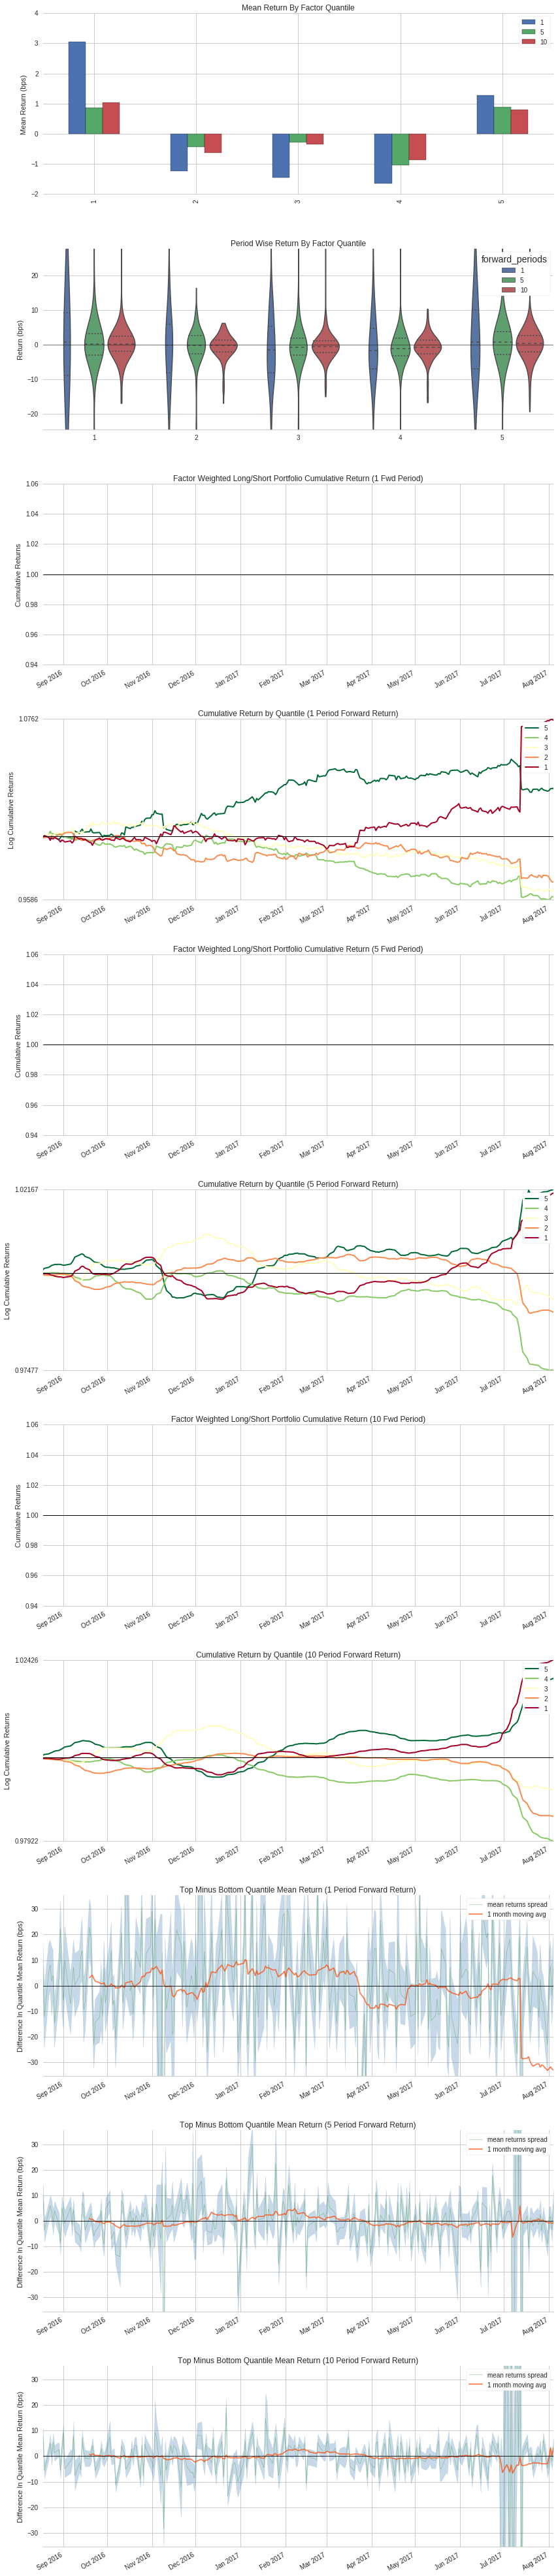

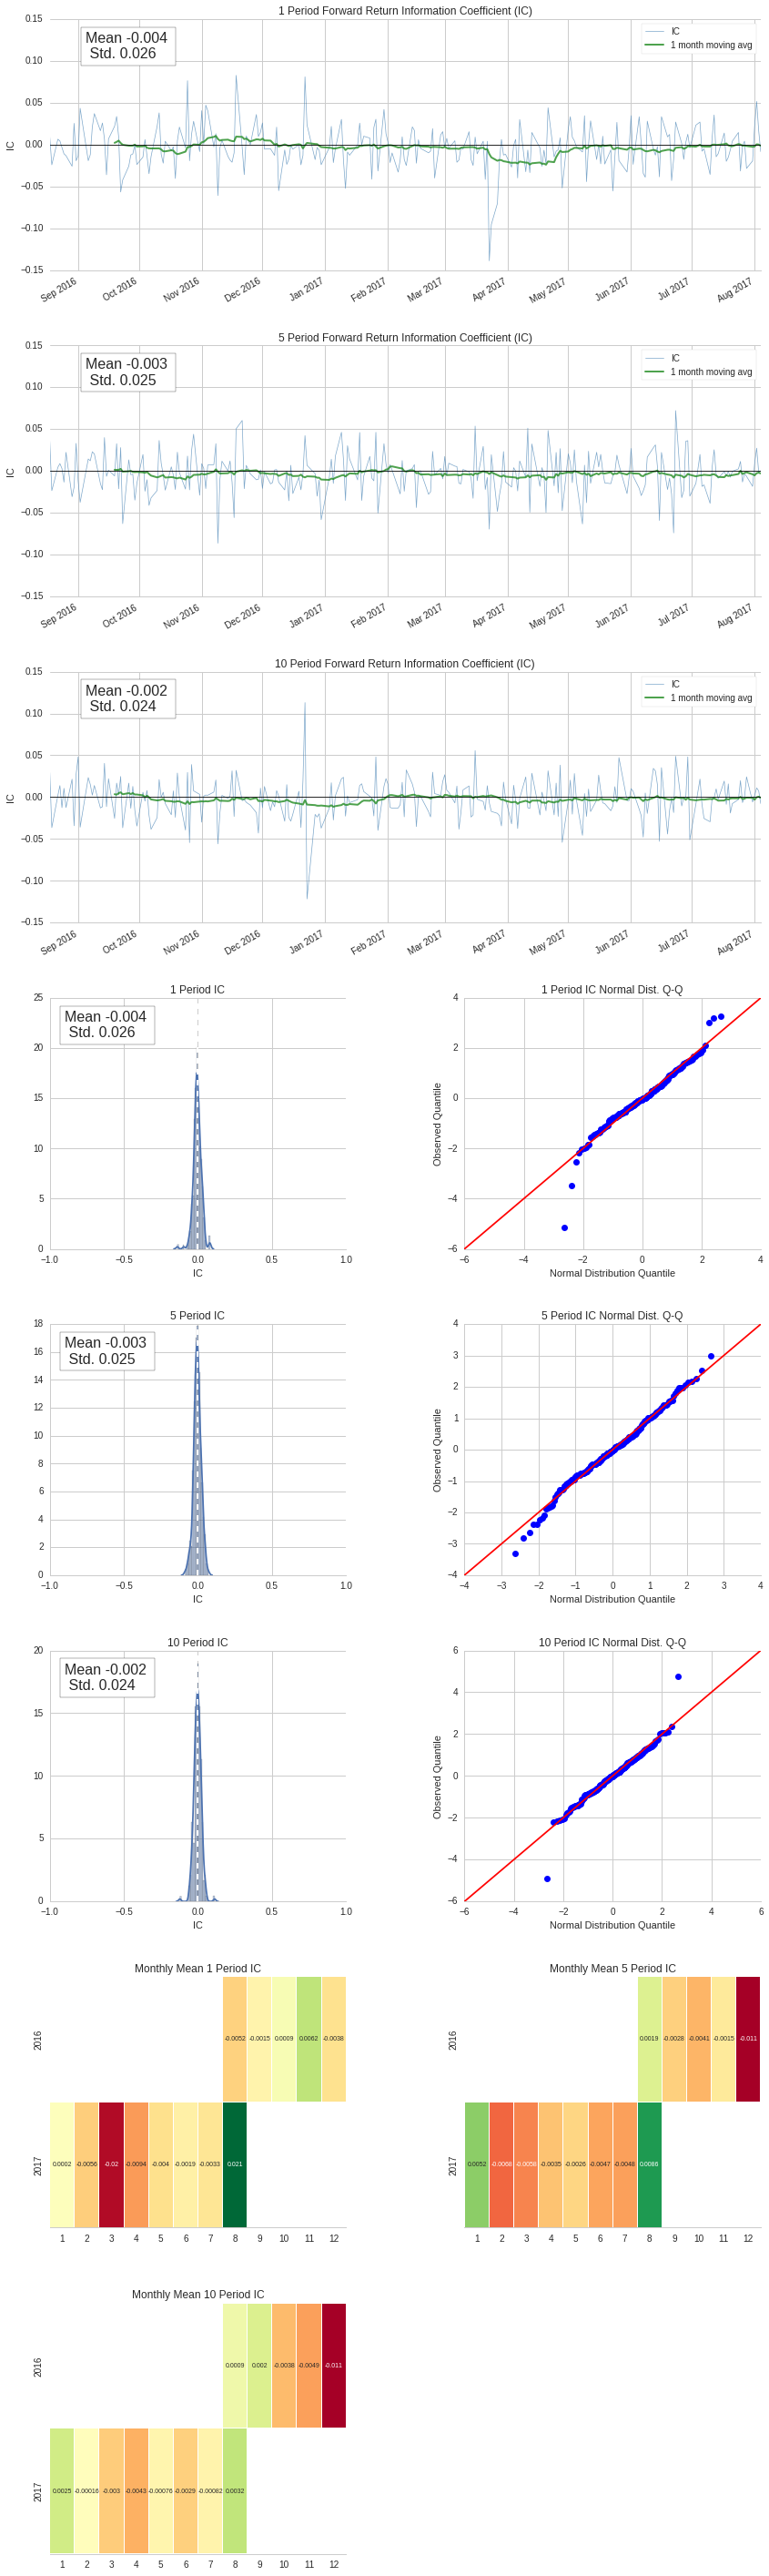

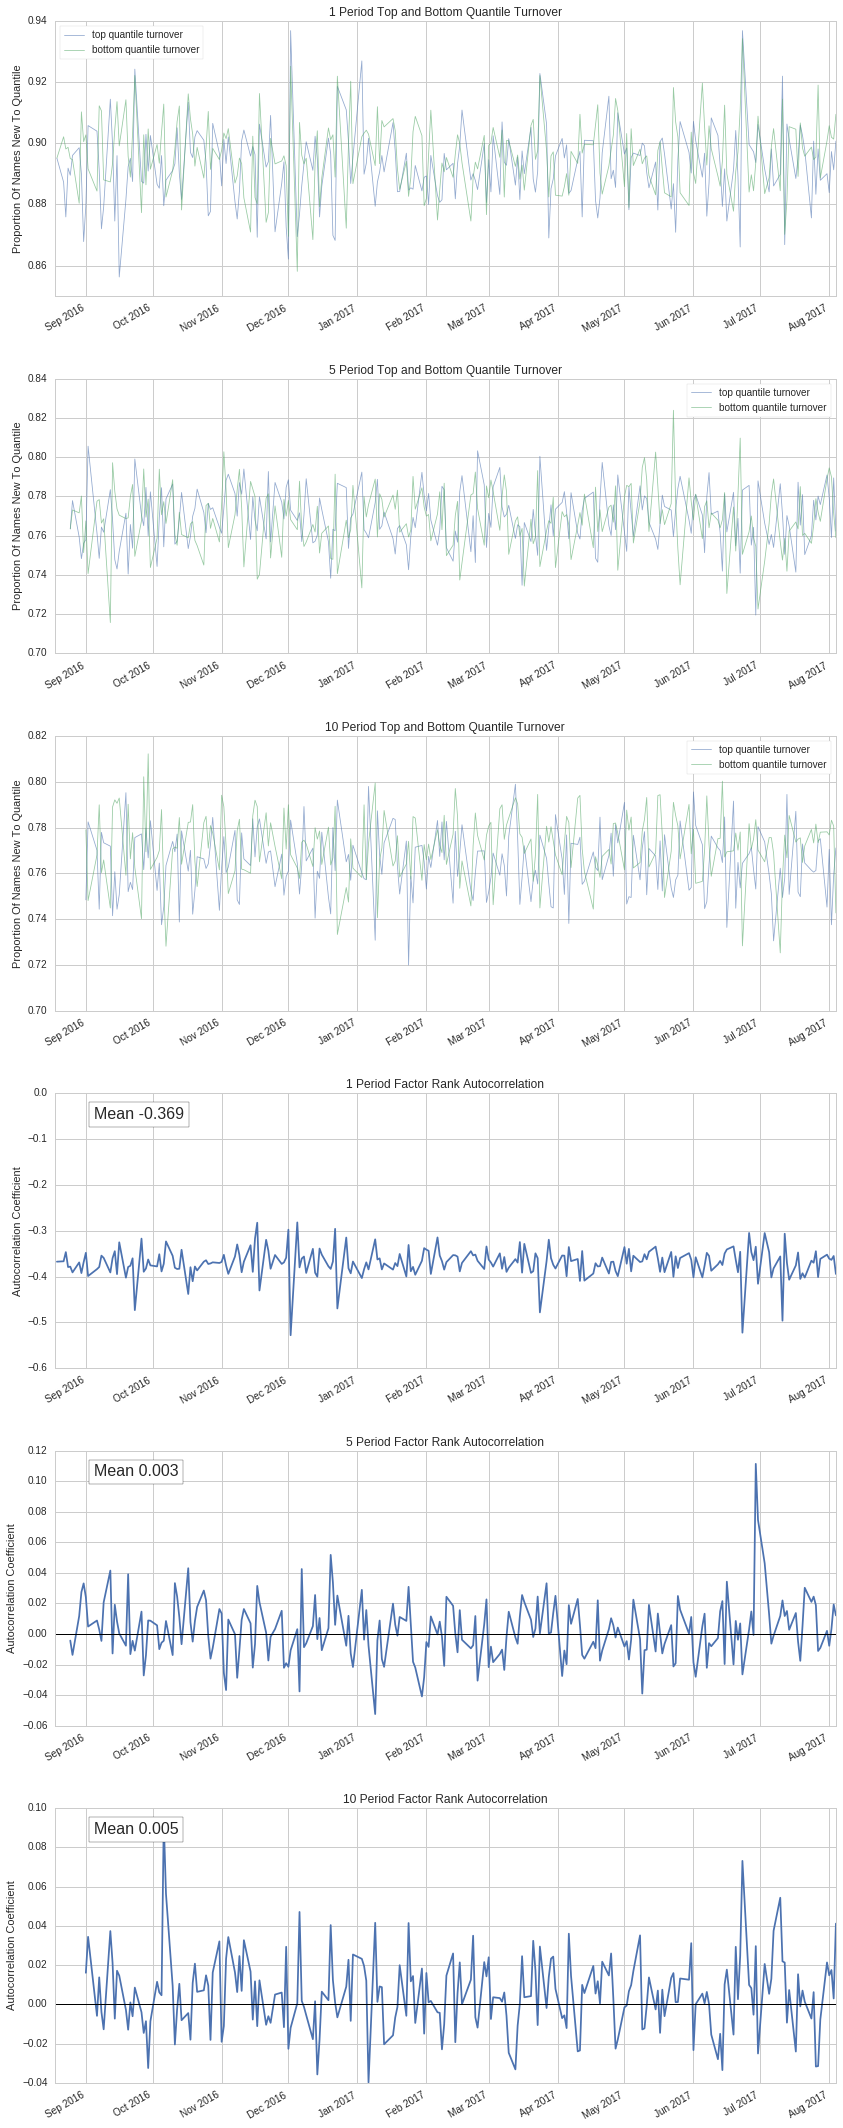

In [78]:
# Test FiveDayMoneyFlowVol.
factor_data_2 = alphalens.utils.get_clean_factor_and_forward_returns(results_1['FiveDayMoneyFlowVol'],
                                                                   pricing,
                                                                   quantiles=5,
                                                                   groupby=results_1['Sector'],
                                                                   periods=(1,5,10))

alphalens.tears.create_full_tear_sheet(factor_data_2)

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                            
1               -49.000000 -0.008621 -0.154290  0.344943  355343  20.005686
2                -0.127344  0.023026 -0.018591  0.019120  355197  19.997467
3                -0.056618  0.070588  0.006959  0.014782  355217  19.998593
4                -0.027261  0.144930  0.031563  0.022308  355169  19.995890
5                 0.000974  1.245536  0.114107  0.084239  355284  20.002365

Returns Analysis


1      5      10
Ann. alpha                                    -0.206 -0.026  0.055
beta                                          -0.172 -0.484 -0.630
Mean Period Wise Return Top Quantile (bps)     2.711  6.721  8.731
Mean Period Wise Return Bottom Quantile (bps)  2.225  5.890  5.387
Mean Period Wise Spread (bps)                  0.460  0.166  0.357

Information Analysis


1      5      10
IC Mean      0.001 -0.009 -0.016
IC Std.      0.089  0.103  0.107
t-stat(IC)   0.248 -1.376 -2.292
p-value(IC)  0.804  0.170  0.023
IC Skew     -0.211 -0.298 -0.179
IC Kurtosis -0.016 -0.100 -0.156
Ann. IR      0.253 -1.401 -2.334

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.170  0.363  0.512
Quantile 2 Mean Turnover   0.375  0.604  0.705
Quantile 3 Mean Turnover   0.415  0.606  0.675
Quantile 4 Mean Turnover   0.372  0.601  0.697
Quantile 5 Mean Turnover   0.176  0.380  0.538

1      5     10
Mean Factor Rank Autocorrelation  0.911  0.655  0.399

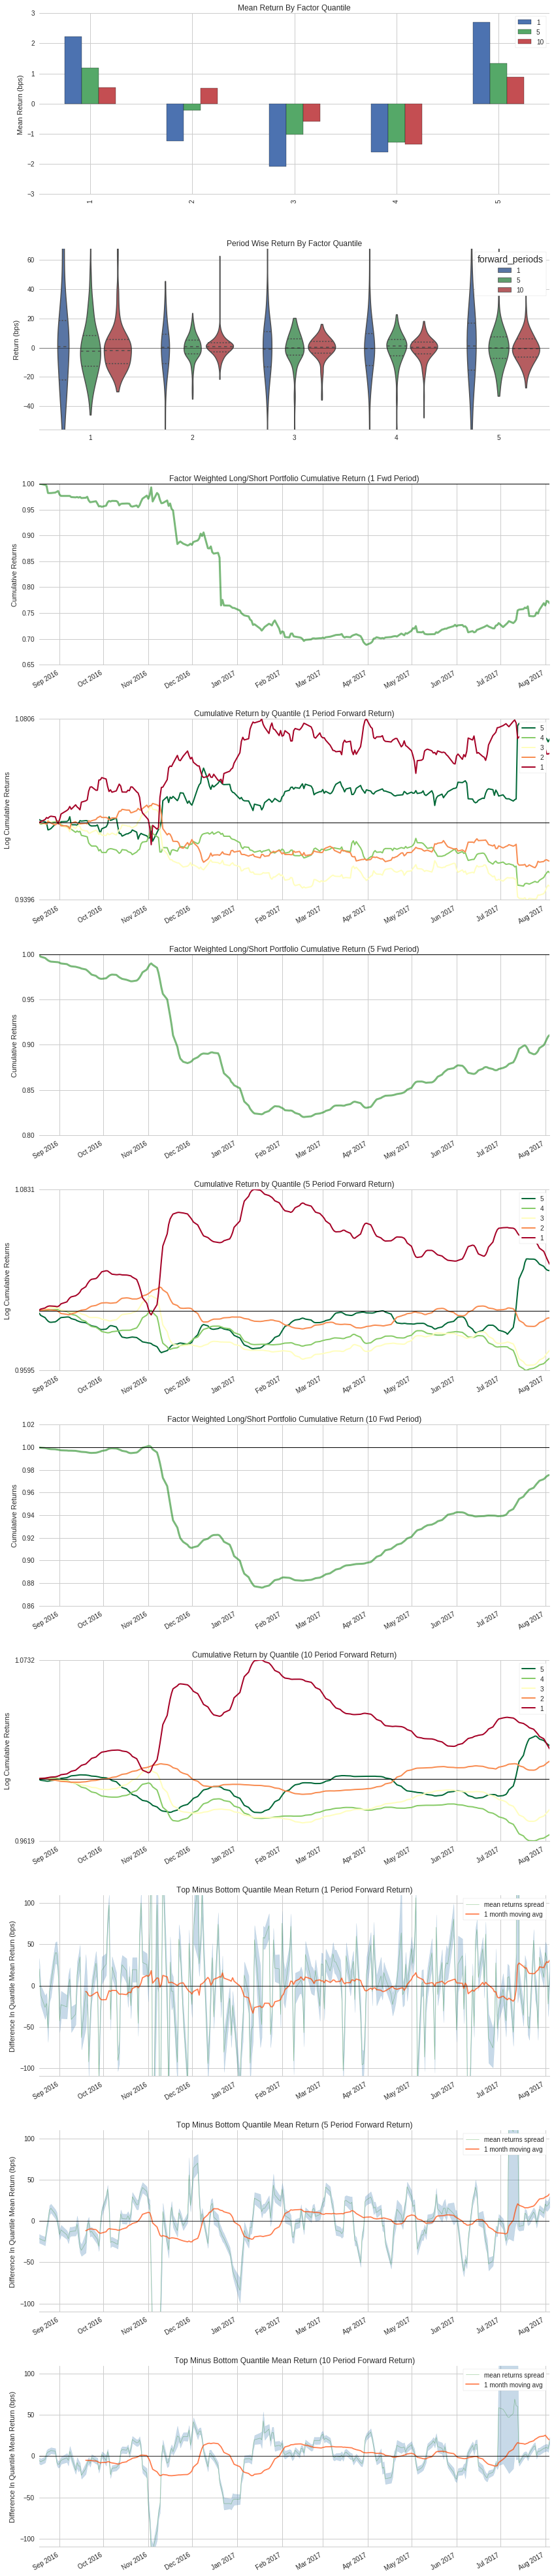

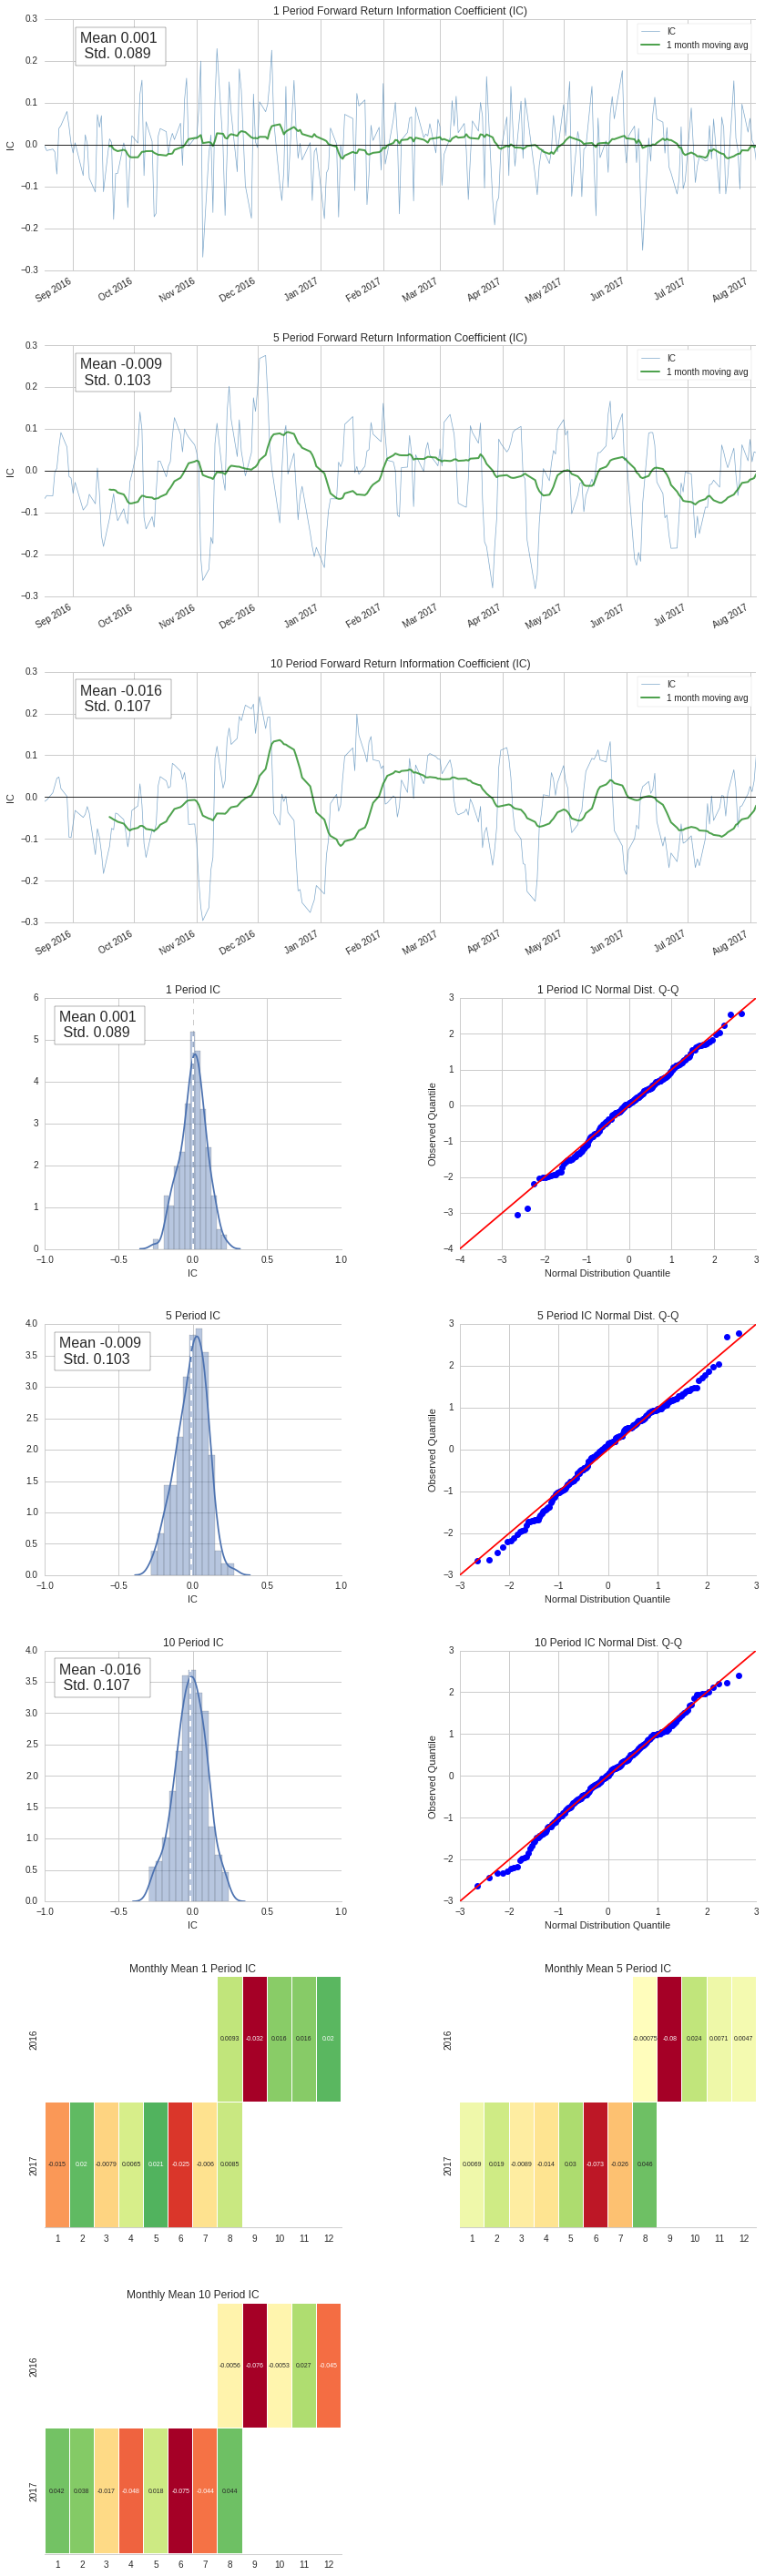

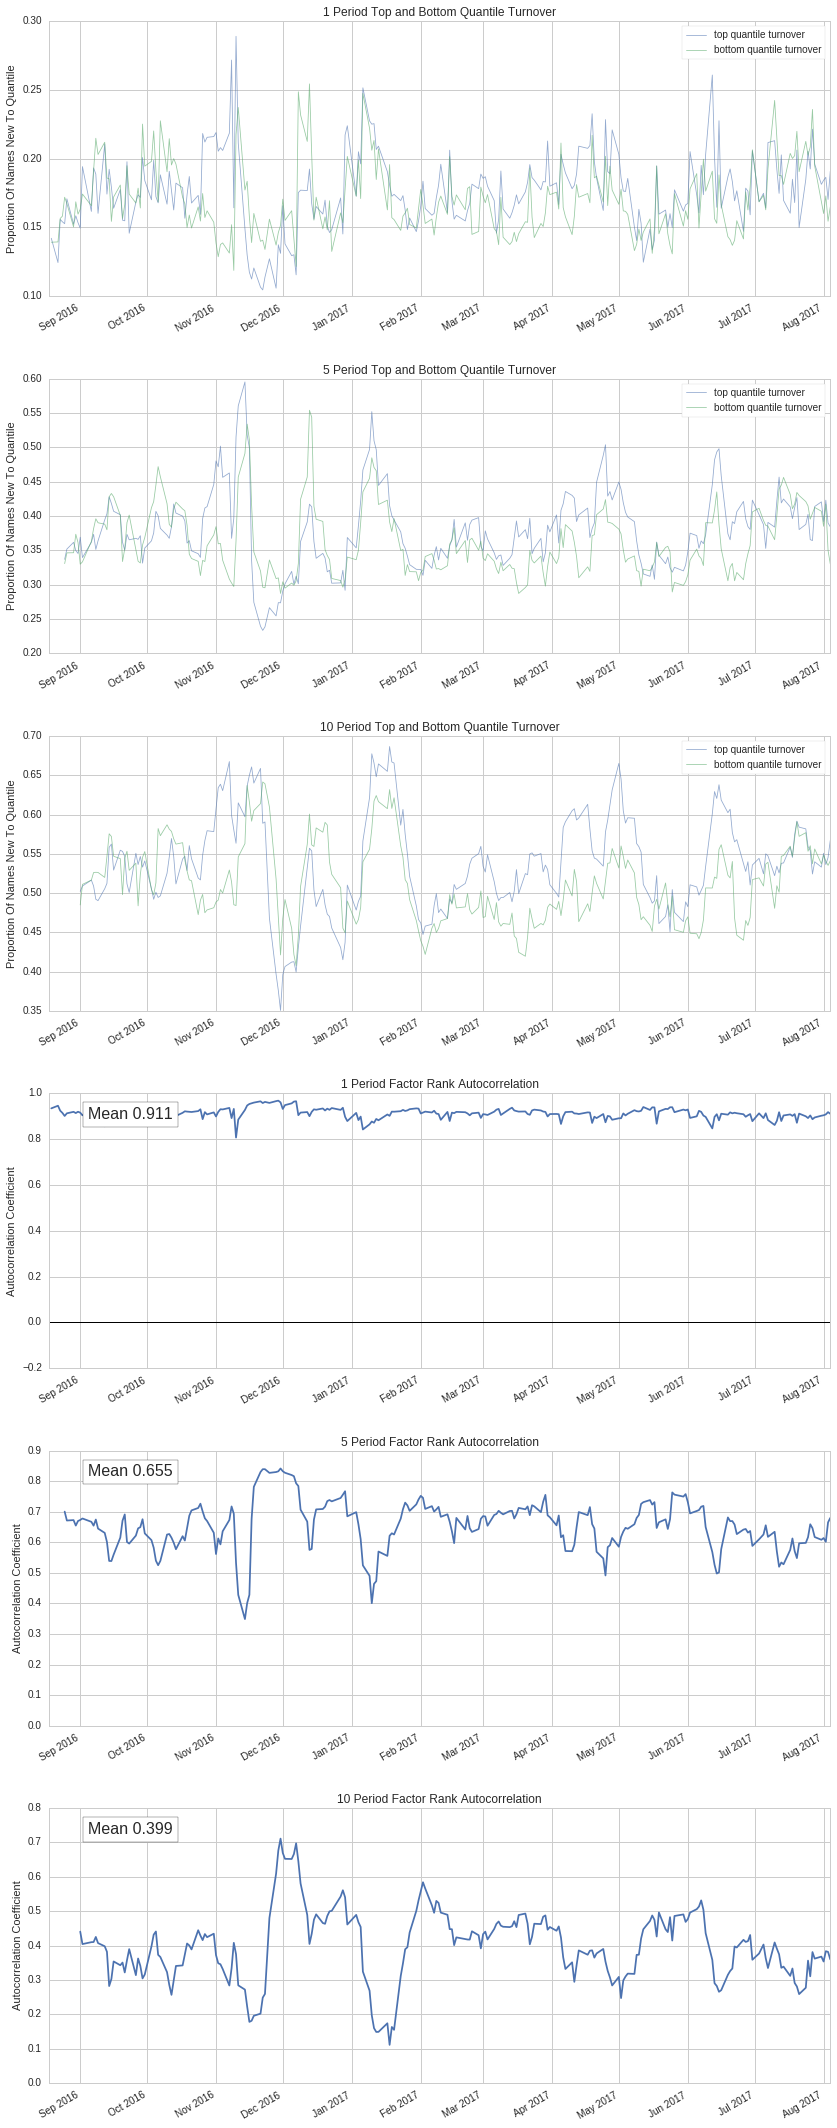

In [79]:
# Test FourWeekReturn.
factor_data_3 = alphalens.utils.get_clean_factor_and_forward_returns(results_1['FourWeekReturn'],
                                                                   pricing,
                                                                   quantiles=5,
                                                                   groupby=results_1['Sector'],
                                                                   periods=(1,5,10))

alphalens.tears.create_full_tear_sheet(factor_data_3)

## Accelerating Sales
This factor is comprised of the following sub-factors:
- 3-Month Momentum in Trailing 12-Month Sales
- 6-Month Momentum in Trailing 12-Month Sales
- Change in Slope of 4-Quarter Trendline through Quarterly Sales

In [108]:
class TTMSales(CustomFactor):  
    inputs = [morningstar.income_statement.total_revenue]
    window_length = 252
    
    def compute(self, today, assets, out, sales):
        out[:] = (sales[0] - sales[-1]) / sales[-1]
        
class ThreeMonthTTMSales(CustomFactor):
    inputs = [TTMSales()]
    window_length = 63
    
    def compute(self, today, assets, out, ttm_sales):
        out[:] = (ttm_sales[0] - ttm_sales[-252]) / ttm_sales[-252]
        
class SixMonthTTMSales(CustomFactor):
    inputs = [TTMSales()]
    window_length = 126
    
    def compute(self, today, assets, out, ttm_sales):
        out[:] = (ttm_sales[0] - ttm_sales[-252]) / ttm_sales[-252]

In [109]:
full_pipeline_2 = Pipeline(
    columns={
        'SPY Proxy': SPY_proxy(),
        'ThreeMonthTTMSales': ThreeMonthTTMSales(),
        'SixMonthTTMSales': SixMonthTTMSales(),
        'Sector': Sector(),
    }
)

results_2 = run_pipeline(full_pipeline_2, start_date='2016-08-18', end_date='2017-08-18')
results_2.head()

NonWindowSafeInput: Can't compute windowed expression ThreeMonthTTMSales((TTMSales((income_statement.total_revenue::float64,), window_length=252),), window_length=63) with windowed input TTMSales((income_statement.total_revenue::float64,), window_length=252).